## From The standard Node-Link data to Network
Data Source : http://nodelink.its.go.kr/data/data01.aspx

The standard node-link files consist of two kinds of shape files(node, link).

The _shapefile_ format is a popular geospatial vector data format for geographic information system (GIS) software. It is developed and regulated by Esri as a (mostly) open specification for data interoperability among Esri and other GIS software products. [wiki](https://en.wikipedia.org/wiki/Shapefile)

To construct network, we should modifiy shpfiles.

In [32]:
import shapefile #the pyshp module : Should install pyshp module.
import pandas as pd
from pyproj import Proj, transform # Should install pyproj module.
import networkx as nx

If you see an error message that `No module named modulename`, you should install module. To resolve this problem, we need to istall 'pyshp' and 'pyproj'. To do this, we use `pip`. We can install module easily by typing `pip install modulename`. To install `pyshp` and `pyproj`, we type the below codes in `terminal` or `anaconda prompt`.

```
pip install pyshp
pip install pyproj
```
If there is a problem to install pyproj, then do the following; conda install -c anaconda pyproj 

## Construct dataframe by using shp file

In [33]:
# read data (Copy all files from nodelink into nodelink folder: I made it.)
# using old_data
shp_path_node = './nodelink_150105/MOCT_NODE.shp'
sf_node = shapefile.Reader(shp_path_node)
shp_path_link = './nodelink_150105/MOCT_LINK.shp'
sf_link = shapefile.Reader(shp_path_link)

In [34]:
# construct pandas dataframe

#grab the shapefile's field names
# node
fields_node = [x[0] for x in sf_node.fields][1:]
records_node = sf_node.records()
shps = [s.points for s in sf_node.shapes()] # node has coordinate data.
# link
fields_link = [x[0] for x in sf_link.fields][1:]
records_link = sf_link.records()


#write the records into a dataframe
# node
node_dataframe = pd.DataFrame(columns=fields_node, data=records_node)
#add the coordinate data to a column called "coords"
node_dataframe = node_dataframe.assign(coords=shps)
# link
link_dataframe = pd.DataFrame(columns=fields_link, data=records_link)

''' Show the files'''

In [35]:
node_dataframe[1:5]# Show first 5 items.

,NODE_ID,NODE_TYPE,NODE_NAME,TURN_P,REMARK,USER_ID,WORKSTATE,DEPT_CODE,STNL_REG,TMPID,UPLOAD_ID,coords
1,3330016500,104,b'\xb9\xfa\xb1\xb3\xc5\xcd\xb3\xce',0,,korea,5,,333,OEXT3330016500,,"[[229535.21800000034, 250194.52040000074]]"
2,3330015600,104,b'\xb9\xfa\xb1\xb3\xc5\xcd\xb3\xce',0,,korea,5,,333,OEXT3330015600,,"[[229465.27020000014, 249416.52300000004]]"
3,3330014900,101,b'\xb9\xfa\xb1\xb3\xb1\xb3\xc2\xf7\xb7\xce',0,,korea,5,,333,OEXT3330014900,,"[[229455.64099999983, 249249.00129999965]]"
4,3330014600,101,b'\xb9\xfa\xb1\xb3\xb1\xb3\xc2\xf7\xb7\xce',0,,korea,5,,333,OEXT3330014600,,"[[229412.60429999977, 249169.92640000023]]"


Show the file with only if STNL_REG=333/ here "333" is assigned as a string

In [36]:
node_dataframe[node_dataframe['STNL_REG'] == str(333)][1:5]

,NODE_ID,NODE_TYPE,NODE_NAME,TURN_P,REMARK,USER_ID,WORKSTATE,DEPT_CODE,STNL_REG,TMPID,UPLOAD_ID,coords
1,3330016500,104,b'\xb9\xfa\xb1\xb3\xc5\xcd\xb3\xce',0,,korea,5,,333,OEXT3330016500,,"[[229535.21800000034, 250194.52040000074]]"
2,3330015600,104,b'\xb9\xfa\xb1\xb3\xc5\xcd\xb3\xce',0,,korea,5,,333,OEXT3330015600,,"[[229465.27020000014, 249416.52300000004]]"
3,3330014900,101,b'\xb9\xfa\xb1\xb3\xb1\xb3\xc2\xf7\xb7\xce',0,,korea,5,,333,OEXT3330014900,,"[[229455.64099999983, 249249.00129999965]]"
4,3330014600,101,b'\xb9\xfa\xb1\xb3\xb1\xb3\xc2\xf7\xb7\xce',0,,korea,5,,333,OEXT3330014600,,"[[229412.60429999977, 249169.92640000023]]"


We observe that **NODE_NAME**, **ROAD_NAME** are not string and **coords** is strange coordinate system. We will fix later.

Now, we restirct data for some city before we fix.

<img src="https://trello-attachments.s3.amazonaws.com/59103d52b56a24582f00dc97/5ac8b77017464fe59d4b728e/6388818a77f59b02e011068d58dc8145/image.png"></img>

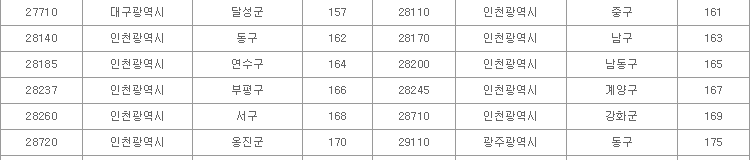

http://nodelink.its.go.kr/intro/intro06_05.aspx
Please find more info from nodelink site

**광역/특별시의 권역코드 (STNL_REG)**
- 서울 : 100 ~ 124
- 부산 : 130 ~ 145
- 대구 : 150 ~ 157
- 인천 : 161 ~ 170
- 광주 : 175 ~ 179
- 대전 : 183 ~ 187
- 울산 : 192 ~ 196

**In this code, we choose Incheon.**

In [37]:
node_dataframe.dtypes # Check data types of columns.

NODE_ID      object
NODE_TYPE    object
NODE_NAME    object
TURN_P       object
REMARK       object
USER_ID      object
WORKSTATE    object
DEPT_CODE    object
STNL_REG     object
TMPID        object
UPLOAD_ID    object
coords       object
dtype: object

In [38]:
# Data restriction
range_STNL_REG=range(161,170) # STNL_REG for Incheon
df_node = pd.DataFrame()
df_link = pd.DataFrame()
for ii in range_STNL_REG:
    res_node = node_dataframe[node_dataframe['STNL_REG'] == str(ii) ] # STNL_REG is not int.
    res_link = link_dataframe[link_dataframe['STNL_REG'] == str(ii) ]
    df_node = pd.concat([df_node,res_node],ignore_index=True) # marge data
    df_link = pd.concat([df_link,res_link],ignore_index=True)

In [39]:
# Change node name in korean 
for idx,row in df_node.iterrows():
    if type(row['NODE_NAME']) == bytes :
        # row['NODE_NAME'] = row['NODE_NAME'].decode('euc_kr')
        row['NODE_NAME'] = row['NODE_NAME'].decode('cp949')

In nodelink data, all positions in nodes are assigned based on **korea 2000 좌표계**. Their positions are changed based on 
**wgs84 (위도/경도)** by using Proj package.

In [40]:
# Change coordinate system
# korea 2000/central belt 2010 (epsg:5186) to wgs84(epsg:4326)
inProj = Proj(init = 'epsg:5186')
outProj= Proj(init = 'epsg:4326')
latitude = []
longitude= []
for idx,row in df_node.iterrows():
    x,y  = row.coords[0][0],row.coords[0][1]  # korea 2000 좌표계
    nx,ny = transform(inProj,outProj,x,y)     # 새로운 좌표계    
    latitude.append(ny)
    longitude.append(nx)
df_node['latitude'] = latitude
df_node['longitude']= longitude
del df_node['coords'] # delete coords

In order to use Gephi, it is essential to have two files node and line file. Also each one has a special properties. That is, node name has to be indexed as an **ID** and link has two names **Source** and **Target**. File in below show that how to change the given form to gephi-type file form.

In [41]:
# Change column name to draw network in Gephi
df_node.rename(columns={'NODE_ID':'Id'},inplace = True)
df_link.rename(columns={'F_NODE':'Source','T_NODE':'Target'},inplace = True)

In [42]:
print(len(df_node))

2200


In [43]:
df_node.head()

,Id,NODE_TYPE,NODE_NAME,TURN_P,REMARK,USER_ID,WORKSTATE,DEPT_CODE,STNL_REG,TMPID,UPLOAD_ID,latitude,longitude
0,1610003100,104,영종대교 서단(상하부도로 합류),0,,seoul,5,00000,161,999,,37.535279,126.560037
1,1610003000,108,공항입구IC(본선),0,,seoul,5,00000,161,999,,37.507276,126.512479
2,1610002900,108,공항입구IC 서측(연결로),0,,icsi,5,00000,161,999,,37.506817,126.503792
3,1610002400,104,삼목지하차도,0,,icsi,5,00000,161,999,,37.491616,126.481301
4,1610002300,108,공항신도시IC 북측(본선 서울방,0,,seoul,5,00000,161,999,,37.489293,126.491712


In [44]:
df_link[1:5]

,LINK_ID,Source,Target,ROAD_USE,LANES,ROAD_RANK,ROAD_NAME,MULTI_LINK,CONNECT,MAX_SPD,...,WORKSTATE,DEPT_CODE,STNL_REG,ROAD_TYPE,ROAD_NO,TMPID,UPLOAD_ID,SOSFNODEID,SOSTNODEID,SHAPE_STLe
1,1610006300,1610003100,1610003000,0,0.0,101,b'\xc0\xce\xc3\xb5\xb1\xb9\xc1\xa6\xb0\xf8\xc7...,0,000,0.0,...,5,00000,161,003,130,,,OEXT1610003100,OEXT1610003000,5288.633501
2,1610006500,1680003800,1610003100,0,0.0,101,b'\xc0\xce\xc3\xb5\xb1\xb9\xc1\xa6\xb0\xf8\xc7...,0,101,0.0,...,5,00000,161,003,130,,,OEXT1680003800,OEXT1610003100,4230.756170
3,1610001500,1610000800,1610000700,0,0.0,101,b'\xc0\xce\xc3\xb5\xb1\xb9\xc1\xa6\xb0\xf8\xc7...,0,101,0.0,...,5,00000,161,000,130,,,OEXT1610000800,OEXT1610000700,637.201873
4,1610027100,1610008600,1630014900,0,0.0,104,b'\xc2\xfc\xbf\xdc\xc0\xfc\xb1\xe6',0,000,0.0,...,5,00000,161,000,0,,,OEXT1610008600,OEXT1630014900,399.876881


# You can save Data as csv formet.

In [45]:
df_node.to_csv('Incheon_nodes_150105.csv') # node list
df_link.to_csv('Incheon_links_150105.csv') # edge(=link) list

In [46]:
df_link.columns

Index(['LINK_ID', 'Source', 'Target', 'ROAD_USE', 'LANES', 'ROAD_RANK',
       'ROAD_NAME', 'MULTI_LINK', 'CONNECT', 'MAX_SPD', 'REST_VEH', 'REST_W',
       'REST_H', 'REMARK', 'USER_ID', 'WORKSTATE', 'DEPT_CODE', 'STNL_REG',
       'ROAD_TYPE', 'ROAD_NO', 'TMPID', 'UPLOAD_ID', 'SOSFNODEID',
       'SOSTNODEID', 'SHAPE_STLe'],
      dtype='object')